# Collisions Severity - Capstone

### This notebook is my submission for the capstone project in which we will analyze the severity of collisions in Seattle are in the United States of America. This project will use data collected from collision records recorded by the Seattle Police Department from 2004 till present.

In [77]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [6]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_102bf9b07d5f4cfab6bcc76fea607c2a = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='YetjlEnukctrskF5npx9QId0JvBbHDYRCG4C02lD158O',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.ap-geo.objectstorage.service.networklayer.com')

body = client_102bf9b07d5f4cfab6bcc76fea607c2a.get_object(Bucket='courseracapstone1-donotdelete-pr-shvbshcnwbuwkz',Key='Data-Collisions.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_csv = pd.read_csv(body)
df_csv.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


## Anayzing the data

In [11]:
print(df_csv.shape)

(194673, 38)


In [15]:
coll_1 = df_csv[df_csv['SEVERITYCODE']==1].count()['SEVERITYCODE']
coll_2 = df_csv[df_csv['SEVERITYCODE']==2].count()['SEVERITYCODE']
print('Amount of property damage collisions = ', coll_1)
print('Amount of collisions with injury = ', coll_2)
print('Property damage to with injury collisions ratio: '+'{:.2f}'.format(coll_1/coll_2))

Amount of property damage collisions =  136485
Amount of collisions with injury =  58188
Property damage to with injury collisions ratio: 2.35


In [16]:
df_csv.columns

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

After understanding the size of the data, we have to select the elements we will use as part of predicting the severity of collissions; and if we look at the Metada provided as part of the capstone project, we have selected the following elements for our exercise:

|Column Name|Description|
|:---|:---|
|COLLISIONTYPE|A keyword describing the collision, eg 'head-on', 'angled', 'cycles', etc.|
|PERSONCOUNT|Total number of people involved in the collision. |
|PEDCOUNT|The number of pedestrians involved in the collision.|
|PEDCYLCOUNT|The number of bicycles involved.|
|VEHCOUNT|The number of vehicles involved in the collision.|
|INCDATE/INCDTTM|Date and time recordings for the incident records.|
|INATTENTIONIND|If collision was due to inattention.|
|UNDERINFL|If driver was under influence of drugs/alchohol.|
|WEATHER|Weather at the time of incident.|
|ROADCOND|Condition of road at the time of incident.|
|LIGHTCOND|Light conditions at the time of incident.|
|SPEEDING|If speeding was a factor in the collision.|

In [18]:
print(df_csv[['INCDATE','INCDTTM']].dtypes)

print(df_csv[['INCDATE','INCDTTM']].describe())

df_csv[['INCDATE','INCDTTM']].head(20)

INCDATE    object
INCDTTM    object
dtype: object
                       INCDATE    INCDTTM
count                   194673     194673
unique                    5985     162058
top     2006/11/02 00:00:00+00  11/2/2006
freq                        96         96


,INCDATE,INCDTTM
0,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM
1,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM
2,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM
3,2013/03/29 00:00:00+00,3/29/2013 9:26:00 AM
4,2004/01/28 00:00:00+00,1/28/2004 8:04:00 AM
5,2019/04/20 00:00:00+00,4/20/2019 5:42:00 PM
6,2008/12/09 00:00:00+00,12/9/2008
7,2020/04/15 00:00:00+00,4/15/2020 5:47:00 PM
8,2006/06/15 00:00:00+00,6/15/2006 1:00:00 PM
9,2006/03/20 00:00:00+00,3/20/2006 3:49:00 PM


In [19]:
df_csv['DATETIME']=df_csv['INCDTTM'].astype('datetime64[ns]')
print(df_csv['DATETIME'].dtypes)
print(df_csv['DATETIME'].describe())
df_csv[['DATETIME']].head(15)

datetime64[ns]
count                  194673
unique                 162058
top       2006-11-02 00:00:00
freq                       96
first     2004-01-01 00:00:00
last      2020-05-20 00:00:00
Name: DATETIME, dtype: object


,DATETIME
0,2013-03-27 14:54:00
1,2006-12-20 18:55:00
2,2004-11-18 10:20:00
3,2013-03-29 09:26:00
4,2004-01-28 08:04:00
5,2019-04-20 17:42:00
6,2008-12-09 00:00:00
7,2020-04-15 17:47:00
8,2006-06-15 13:00:00
9,2006-03-20 15:49:00


After understanding the volume and time, we will proceed to grouping the collisions in categories. These categories include year, severity classification,  type of collision and rate of severity.

Following the grouping, we will plot the data on the graph to analyze the trends.

In [20]:
df_annual = df_csv.groupby([df_csv.DATETIME.dt.year,'SEVERITYCODE']).size().unstack(fill_value=0)
df_annual.head()

SEVERITYCODE,1,2
DATETIME,,
2004,8218,3647
2005,10665,4450
2006,10838,4350
2007,10439,4017
2008,9893,3767


In [21]:
df_annual.reset_index(drop=False,inplace=True)
df_annual.columns = ['Year','Property','Injury']
df_annual.head()

,Year,Property,Injury
0,2004,8218,3647
1,2005,10665,4450
2,2006,10838,4350
3,2007,10439,4017
4,2008,9893,3767


In [22]:
df_annual['Total'] = df_annual['Property'] + df_annual['Injury']
df_annual['Severe_rate'] = df_annual['Injury'] / df_annual['Total']
df_annual.drop(df_annual.tail(1).index,inplace=True)
df_annual.tail()

,Year,Property,Injury,Total,Severe_rate
11,2015,9243,3752,12995,0.288726
12,2016,7945,3714,11659,0.318552
13,2017,7454,3419,10873,0.314449
14,2018,7061,3358,10419,0.322296
15,2019,6350,3062,9412,0.325329


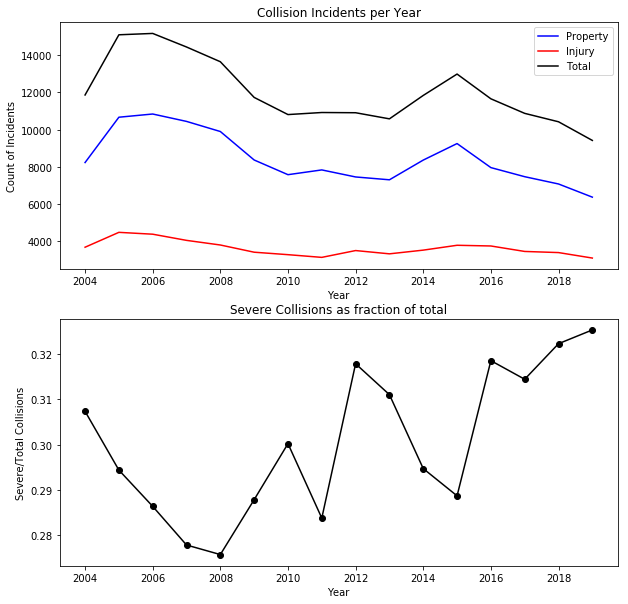

In [23]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))

ax1.plot('Year','Property',data=df_annual,marker='',color='blue')
ax1.plot('Year','Injury',data=df_annual,marker='',color='red')
ax1.plot('Year','Total',data=df_annual,marker='',color='k')
ax1.set(title='Collision Incidents per Year',xlabel = 'Year',ylabel='Count of Incidents')
ax1.legend()

ax2.plot('Year','Severe_rate',data=df_annual,marker='o',color='k')
ax2.set(title='Severe Collisions as fraction of total',xlabel='Year',ylabel='Severe/Total Collisions')

plt.show()

#### Analysis: From the data, we can clearly see that the major amount of collisions are property incidents and the amount have dropped between 2004 and present. Despit the decrease in the overall amount of collisions, the severity in general have fluctuated reaching its lowest in 2008 and its highest in 2020.

#### In order to further understand and analyze our data, we will zoom deeper into the frequency of the collisions by weekday and time of day, and analyze the different types of collisions and the people involved.

In [24]:
df_exp = df_csv[['DATETIME','COLLISIONTYPE','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT','INATTENTIONIND','UNDERINFL',
                'WEATHER','ROADCOND','LIGHTCOND','SPEEDING','SEVERITYCODE']]
print(df_exp.shape)
df_exp.head()

(194673, 13)


,DATETIME,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,SEVERITYCODE
0,2013-03-27 14:54:00,Angles,2,0,0,2,NaN,N,Overcast,Wet,Daylight,NaN,2
1,2006-12-20 18:55:00,Sideswipe,2,0,0,2,NaN,0,Raining,Wet,Dark - Street Lights On,NaN,1
2,2004-11-18 10:20:00,Parked Car,4,0,0,3,NaN,0,Overcast,Dry,Daylight,NaN,1
3,2013-03-29 09:26:00,Other,3,0,0,3,NaN,N,Clear,Dry,Daylight,NaN,1
4,2004-01-28 08:04:00,Angles,2,0,0,2,NaN,0,Raining,Wet,Daylight,NaN,2


In [25]:
df_day = df_exp.groupby([df_exp.DATETIME.dt.dayofweek,'SEVERITYCODE']).size().unstack(fill_value=0)
df_day.reset_index(drop=False,inplace=True)
df_day.columns = ['Weekday','Property','Injury']
df_day['Total'] = df_day['Property'] + df_day['Injury']
df_day['inj_rate'] = df_day['Injury'] / df_day['Total']
df_day

,Weekday,Property,Injury,Total,inj_rate
0,0,18365,7973,26338,0.302719
1,1,19825,8731,28556,0.305750
2,2,20021,8757,28778,0.304295
3,3,20306,9018,29324,0.307530
4,4,22774,9559,32333,0.295642
5,5,19342,8047,27389,0.293804
6,6,15852,6103,21955,0.277978


Total collisions in number:  194673
Collisions on weekdays in number:  145329
Collisions on weekends in number:  49344


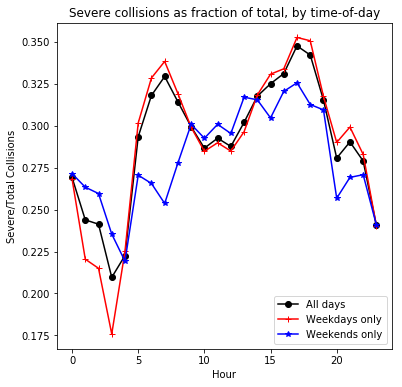

In [27]:
df_hour = df_exp.groupby([df_exp.DATETIME.dt.hour,'SEVERITYCODE']).size().unstack(fill_value=0)
df_hour.reset_index(drop=False,inplace=True)
df_hour.columns = ['Hour','Property','Injury']
df_hour['Total'] = df_hour['Property'] + df_hour['Injury']
df_hour['inj_rate'] = df_hour['Injury'] / df_hour['Total']

wkdays = [0,1,2,3,4]
df_hour2 = df_exp[df_exp.DATETIME.dt.dayofweek.isin(wkdays)].groupby([df_exp.DATETIME.dt.hour,'SEVERITYCODE']).size().unstack(fill_value=0)
df_hour2.reset_index(drop=False,inplace=True)
df_hour2.columns = ['Hour','Property','Injury']
df_hour2['Total'] = df_hour2['Property'] + df_hour2['Injury']
df_hour2['inj_rate'] = df_hour2['Injury'] / df_hour2['Total']

df_hour3 = df_exp[~df_exp.DATETIME.dt.dayofweek.isin(wkdays)].groupby([df_exp.DATETIME.dt.hour,'SEVERITYCODE']).size().unstack(fill_value=0)
df_hour3.reset_index(drop=False,inplace=True)
df_hour3.columns = ['Hour','Property','Injury']
df_hour3['Total'] = df_hour3['Property'] + df_hour3['Injury']
df_hour3['inj_rate'] = df_hour3['Injury'] / df_hour3['Total']

print('Total collisions in number: ', df_hour['Total'].sum())
print('Collisions on weekdays in number: ', df_hour2['Total'].sum())
print('Collisions on weekends in number: ', df_hour['Total'].sum() - df_hour2['Total'].sum())

plt.figure(figsize=(6,6))
plt.plot('Hour','inj_rate',data=df_hour,marker='o',color='k')
plt.plot('Hour','inj_rate',data=df_hour2,marker='+',color='r')
plt.plot('Hour','inj_rate',data=df_hour3,marker='*',color='b')
plt.title('Severe collisions as fraction of total, by time-of-day')
plt.xlabel('Hour')
plt.ylabel('Severe/Total Collisions')
plt.legend(['All days','Weekdays only','Weekends only'],loc=4)
plt.show()

#### Analysis: As expected the total volume of collisions is higher for weekdays than weekends. The volume gradually increased to a peak on Fridays before dropping on Saturday and Sunday. Separately, The severity and amount of collisions is at its highest during the middle of the day.

Text(0, 0.5, 'Severe/Total Collisions')

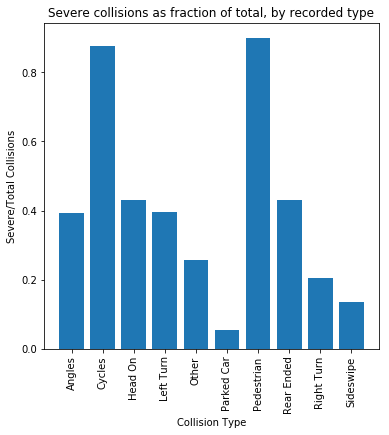

In [28]:
df_type = df_exp.groupby(['COLLISIONTYPE','SEVERITYCODE']).size().unstack(fill_value=0)
df_type.reset_index(drop=False,inplace=True)
df_type.columns = ['Type','Property','Injury']
df_type['Total'] = df_type['Property'] + df_type['Injury']
df_type['inj_rate'] = df_type['Injury'] / df_type['Total']

plt.figure(figsize=(6,6))
plt.bar(df_type['Type'],df_type['inj_rate'])
plt.title('Severe collisions as fraction of total, by recorded type')
plt.xlabel('Collision Type')
plt.xticks(rotation=90)
plt.ylabel('Severe/Total Collisions')

#### Analysis: From the graph we can see that the highest number of collisions and severity occured as a result of cycles and pedestrians.

In [29]:
df_exp['PERSONCOUNT'].value_counts()

2     114231
3      35553
4      14660
1      13154
5       6584
0       5544
6       2702
7       1131
8        533
9        216
10       128
11        56
12        33
13        21
14        19
15        11
17        11
16         8
44         6
18         6
20         6
25         6
19         5
26         4
22         4
27         3
28         3
29         3
47         3
32         3
34         3
37         3
23         2
21         2
24         2
30         2
36         2
57         1
31         1
35         1
39         1
41         1
43         1
48         1
53         1
54         1
81         1
Name: PERSONCOUNT, dtype: int64

[(-1, 11)]

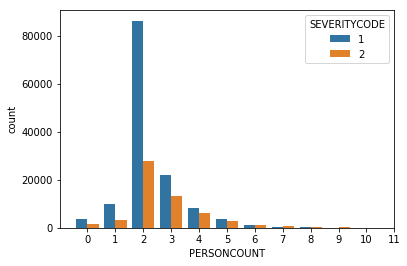

In [30]:
ax = sns.countplot(x='PERSONCOUNT',hue='SEVERITYCODE',data=df_exp)
ax.set(xlim=(-1,11))

#### Analysis: From the graph we can see that the highest number of collisions involved 2 people, and the biggest range involved 1-5 people. This range should be more inspected.

In [31]:
df_exp['PEDCOUNT'].value_counts()

0    187734
1      6685
2       226
3        22
4         4
6         1
5         1
Name: PEDCOUNT, dtype: int64

[(-1, 4)]

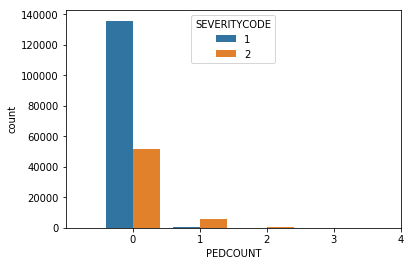

In [32]:
ax = sns.countplot(x='PEDCOUNT',hue='SEVERITYCODE',data=df_exp)
ax.set(xlim=(-1,4))

#### Analysis: From the graph we can see that pedestrians struck by vehicles are more likely to withstand injuries than not.

In [33]:
df_exp['PEDCYLCOUNT'].value_counts()

0    189189
1      5441
2        43
Name: PEDCYLCOUNT, dtype: int64

[(-1, 3)]

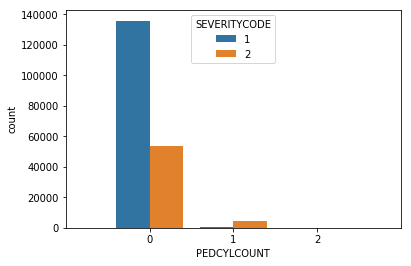

In [34]:
ax = sns.countplot(x='PEDCYLCOUNT',hue='SEVERITYCODE',data=df_exp)
ax.set(xlim=(-1,3))

In [35]:
df_exp['VEHCOUNT'].value_counts()

2     147650
1      25748
3      13010
0       5085
4       2426
5        529
6        146
7         46
8         15
9          9
11         6
10         2
12         1
Name: VEHCOUNT, dtype: int64

[(-1, 7)]

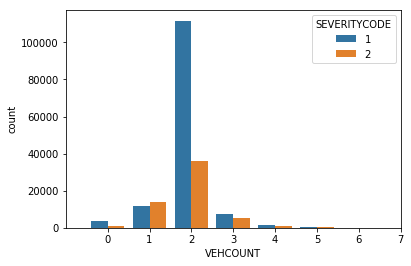

In [36]:
ax = sns.countplot(x='VEHCOUNT',hue='SEVERITYCODE',data=df_exp)
ax.set(xlim=(-1,7))

#### Analysis: From the graph we can see that collisions involving one vehicle have resulted in more incidents with injury than property damange.

In [37]:
df_exp[df_exp['VEHCOUNT']==1].groupby(['COLLISIONTYPE','SEVERITYCODE']).size().unstack(fill_value=0)

SEVERITYCODE,1,2
COLLISIONTYPE,,
Angles,3,24
Cycles,660,4479
Head On,1,1
Left Turn,2,16
Other,10298,3688
Parked Car,10,5
Pedestrian,664,5868
Rear Ended,1,1
Right Turn,0,3


In [38]:
df_exp['INATTENTIONIND'].value_counts()

Y    29805
Name: INATTENTIONIND, dtype: int64

In [39]:
df_exp['INATTENTIONIND'].fillna('N',inplace=True)
df_exp['INATTENTIONIND'].value_counts()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


N    164868
Y     29805
Name: INATTENTIONIND, dtype: int64

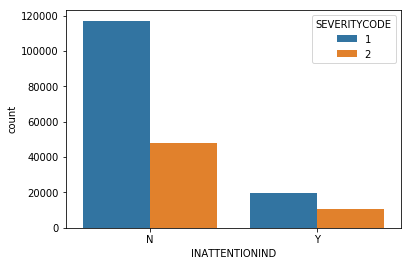

In [40]:
ax = sns.countplot(x='INATTENTIONIND',hue='SEVERITYCODE',data=df_exp)

In [41]:
df_attn = df_exp.groupby(['INATTENTIONIND','SEVERITYCODE']).size().unstack(fill_value=0)
df_attn.reset_index(drop=False,inplace=True)
df_attn.columns = ['State','Property','Injury']
df_attn['Total'] = df_attn['Property'] + df_attn['Injury']
print('Rate of Injury for inattentive collisions (Y): '+'{:.2f}'.format(df_attn.loc[0,'Injury']/df_attn.loc[0,'Total']))
print('Rate of Injury for attentive collisions (N): '+'{:.2f}'.format(df_attn.loc[1,'Injury']/df_attn.loc[1,'Total']))
df_attn

Rate of Injury for inattentive collisions (Y): 0.29
Rate of Injury for attentive collisions (N): 0.35


,State,Property,Injury,Total
0,N,117077,47791,164868
1,Y,19408,10397,29805


In [42]:
df_exp['UNDERINFL'].value_counts()

N    100274
0     80394
Y      5126
1      3995
Name: UNDERINFL, dtype: int64

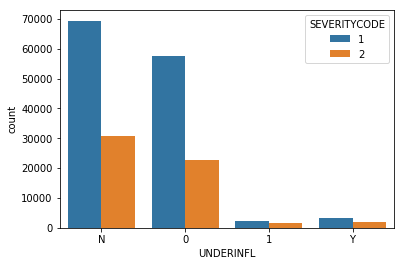

In [43]:
ax = sns.countplot(x='UNDERINFL',hue='SEVERITYCODE',data=df_exp)

In [44]:
df_infl = df_exp.groupby(['UNDERINFL','SEVERITYCODE']).size().unstack(fill_value=0)
df_infl.reset_index(drop=False,inplace=True)
df_infl.columns = ['State','Property','Injury']
df_infl['Total'] = df_infl['Property'] + df_infl['Injury']
print('Rate of Injury for influenced collisions (Y, 1): '+'{:.2f}'.format(
    (df_infl.loc[1,'Injury']+df_infl.loc[3,'Injury'])/(df_infl.loc[1,'Total']+df_infl.loc[3,'Total'])))
print('Rate of Injury for sober collisions (N, 0): '+'{:.2f}'.format(
    (df_infl.loc[0,'Injury']+df_infl.loc[2,'Injury'])/(df_infl.loc[0,'Total']+df_infl.loc[2,'Total'])))

Rate of Injury for influenced collisions (Y, 1): 0.39
Rate of Injury for sober collisions (N, 0): 0.30


#### Analysis: From the data we can conclude that collisions where drugs or alcohol were involved resulted in injury at a higher rate than collisions where no drugs or alcohol were involved.

#### Next we're going to analyze the weather effect on collisions.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

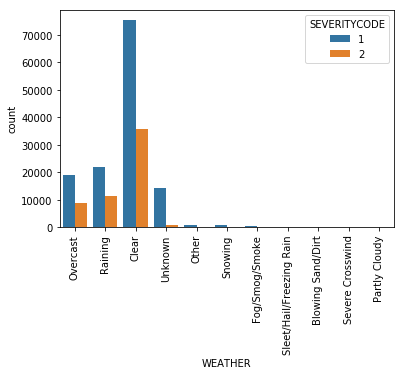

In [45]:
ax=sns.countplot(x='WEATHER',hue='SEVERITYCODE',data=df_exp)
plt.xticks(rotation=90)

In [46]:
df_wea = df_exp.groupby(['WEATHER','SEVERITYCODE']).size().unstack(fill_value=0)
df_wea.reset_index(drop=False,inplace=True)
df_wea.columns = ['Weather','Property','Injury']
df_wea['Total'] = df_wea['Property'] + df_wea['Injury']
df_wea['inj_rate'] = df_wea['Injury'] / df_wea['Total']
df_wea

,Weather,Property,Injury,Total,inj_rate
0,Blowing Sand/Dirt,41,15,56,0.267857
1,Clear,75295,35840,111135,0.322491
2,Fog/Smog/Smoke,382,187,569,0.328647
3,Other,716,116,832,0.139423
4,Overcast,18969,8745,27714,0.315544
5,Partly Cloudy,2,3,5,0.600000
6,Raining,21969,11176,33145,0.337185
7,Severe Crosswind,18,7,25,0.280000
8,Sleet/Hail/Freezing Rain,85,28,113,0.247788
9,Snowing,736,171,907,0.188534


In [47]:
w_dict = {'Clear':0,'Partly Cloudy':0,'Overcast':0,'Blowing Sand/Dirt':1,'Fog/Smog/Smoke':1,'Raining':1,
         'Severe Crosswind':1,'Sleet/Hail/Freezing Rain':1,'Snowing':1,'Other':2,'Unknown':2}
#extract just the weather and severity columns for this investigation
df_weather = df_exp[['WEATHER','SEVERITYCODE']]
#replace the blank values in the WEATHER column and then drop them
df_weather['WEATHER'].replace(r'^\s*$',np.NaN,regex=True)
df_weather.dropna(axis=0,subset=['WEATHER'],inplace=True)
#replace the values in the WEATHER column with the associated values for the keys in the weather dictionary
df_weather.WEATHER = [w_dict[item] for item in df_weather.WEATHER]
#create a new dataframe to group the output by these new weather categories (0,1,2)
df_wea2 = df_weather.groupby(['WEATHER','SEVERITYCODE']).size().unstack(fill_value=0)
df_wea2.reset_index(drop=False,inplace=True)
df_wea2.columns = ['Weather','Property','Injury']
df_wea2['Total'] = df_wea2['Property'] + df_wea2['Injury']
df_wea2['inj_rate'] = df_wea2['Injury'] / df_wea2['Total']
df_wea2

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,Weather,Property,Injury,Total,inj_rate
0,0,94266,44588,138854,0.321114
1,1,23231,11584,34815,0.332730
2,2,14991,932,15923,0.058532


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

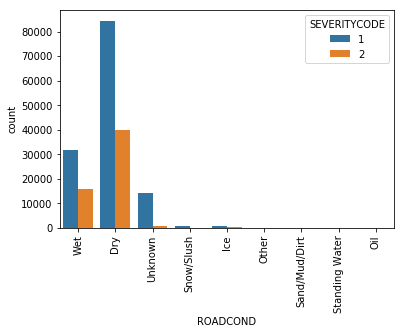

In [48]:
ax = sns.countplot(x='ROADCOND',hue='SEVERITYCODE',data=df_exp)
plt.xticks(rotation=90)

In [49]:
df_cond = df_exp.groupby(['ROADCOND','SEVERITYCODE']).size().unstack(fill_value=0)
df_cond.reset_index(drop=False,inplace=True)
df_cond.columns = ['Condition','Property','Injury']
df_cond['Total'] = df_cond['Property'] + df_cond['Injury']
df_cond['inj_rate'] = df_cond['Injury'] / df_cond['Total']
df_cond

,Condition,Property,Injury,Total,inj_rate
0,Dry,84446,40064,124510,0.321773
1,Ice,936,273,1209,0.225806
2,Oil,40,24,64,0.375000
3,Other,89,43,132,0.325758
4,Sand/Mud/Dirt,52,23,75,0.306667
5,Snow/Slush,837,167,1004,0.166335
6,Standing Water,85,30,115,0.260870
7,Unknown,14329,749,15078,0.049675
8,Wet,31719,15755,47474,0.331866


#### Analysis: From the data we can conclude that rainy weather does increase the rate of injury accidents, but only slightly compared to clear conditions, noting that injury collision rates are not remarkably different from when conditions are dry.

#### Next we will look at the effect of light conditions.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

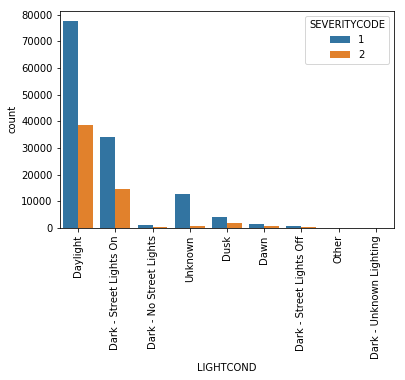

In [50]:
ax = sns.countplot(x='LIGHTCOND',hue='SEVERITYCODE',data=df_exp)
plt.xticks(rotation=90)

In [51]:
df_lite = df_exp.groupby(['LIGHTCOND','SEVERITYCODE']).size().unstack(fill_value=0)
df_lite.reset_index(drop=False,inplace=True)
df_lite.columns = ['Condition','Property','Injury']
df_lite['Total'] = df_lite['Property'] + df_lite['Injury']
df_lite['inj_rate'] = df_lite['Injury'] / df_lite['Total']
df_lite

,Condition,Property,Injury,Total,inj_rate
0,Dark - No Street Lights,1203,334,1537,0.217306
1,Dark - Street Lights Off,883,316,1199,0.263553
2,Dark - Street Lights On,34032,14475,48507,0.298411
3,Dark - Unknown Lighting,7,4,11,0.363636
4,Dawn,1678,824,2502,0.329337
5,Daylight,77593,38544,116137,0.331884
6,Dusk,3958,1944,5902,0.329380
7,Other,183,52,235,0.221277
8,Unknown,12868,605,13473,0.044905


#### Analysis: We can conclude from the data that there is nothing remarkable about dark or poor lighting conditions versus daylight. It is more likely however, that the total volume and severity outcomes are lower during darker conditions because of traffic during those times.

#### Next we will look at the effect of speeding.

In [52]:
df_exp['SPEEDING'].value_counts()

Y    9333
Name: SPEEDING, dtype: int64

In [53]:
df_exp['SPEEDING'].fillna('N',inplace=True)
df_exp['SPEEDING'].value_counts()

N    185340
Y      9333
Name: SPEEDING, dtype: int64

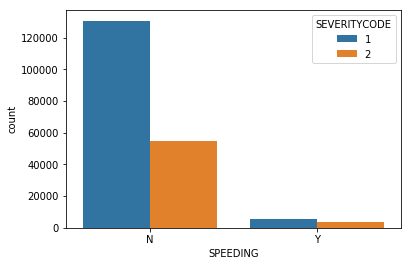

In [54]:
ax = sns.countplot(x='SPEEDING',hue='SEVERITYCODE',data=df_exp)

In [55]:
df_speed = df_exp.groupby(['SPEEDING','SEVERITYCODE']).size().unstack(fill_value=0)
df_speed.reset_index(drop=False,inplace=True)
df_speed.columns = ['Speeding','Property','Injury']
df_speed['Total'] = df_speed['Property'] + df_speed['Injury']
df_speed['inj_rate'] = df_speed['Injury'] / df_speed['Total']
df_speed

,Speeding,Property,Injury,Total,inj_rate
0,N,130683,54657,185340,0.294901
1,Y,5802,3531,9333,0.378335


#### Analysis: From the data we can conclude that the proportion of collisions resulting in injury is 1.28 times higher when speeding is involved compared to when it's not involved.

## Regression Analysis

In [99]:
variable = ["DATETIME","COLLISIONTYPE","PERSONCOUNT","PEDCOUNT","PEDCYLCOUNT","VEHCOUNT","INATTENTIONIND","UNDERINFL","WEATHER","ROADCOND","LIGHTCOND","SPEEDING","SEVERITYCODE"]
accident_model = df_exp[variable]
accident_model.head()
Y = accident_model.loc[:,"SEVERITYCODE"].values
X = accident_model.loc[:,"PERSONCOUNT":"VEHCOUNT"].values

standardized_X = preprocessing.scale(X)
train_x, test_x, train_y, test_y = train_test_split(standardized_X,Y , test_size=0.3, random_state=0)

model = LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=1000)
model.fit(train_x, train_y)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [100]:
model.score(test_x, test_y)

0.7500941748570255

Text(91.68, 0.5, 'true value')

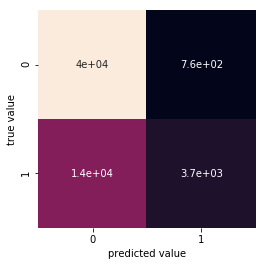

In [101]:
model_y = model.predict(test_x)

mat = confusion_matrix(test_y,model_y)
sns.heatmap(mat, square=True, annot=True, cbar=False) 
plt.xlabel('predicted value')
plt.ylabel('true value')